In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(108129, 14)

In [4]:
test.shape

(63465, 12)

In [5]:
def add_date_fields(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col],unit='s')
    df[date_col+'_month'] = df[date_col].apply(lambda x: x.strftime('%B'))
    df[date_col+'_week'] = df[date_col].apply(lambda x: str(x.strftime('%w')))
    df[date_col+'_day'] = df[date_col].apply(lambda x: str(x.isocalendar()[2]))
    return df
    

In [6]:
unix_cols = ['deadline','state_changed_at','launched_at','created_at']

for x in unix_cols:
    train = add_date_fields(train, x)
    test = add_date_fields(test, x)
    

In [7]:
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,...,deadline_day,state_changed_at_month,state_changed_at_week,state_changed_at_day,launched_at_month,launched_at_week,launched_at_day,created_at_month,created_at_week,created_at_day
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,2009-05-03 06:59:59,2009-05-03 07:00:17,...,7,May,0,7,April,5,5,April,5,5
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,2009-05-15 23:10:00,2009-05-16 00:00:18,...,5,May,6,6,April,3,3,April,2,2
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,2009-05-22 21:26:00,2009-05-22 21:30:18,...,5,May,5,5,May,2,2,May,2,2
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,2009-05-29 00:09:00,2009-05-29 00:15:21,...,5,May,5,5,April,3,3,April,3,3
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,2009-05-31 11:38:00,2009-05-31 11:45:17,...,7,May,0,7,May,5,5,May,5,5


In [8]:
def generate_date_features(df, datecols):
    feature_num = 0
    for i in range(len(datecols)-1):
        for j in range(i+1, len(datecols)):
            df['time_diff_feature'+str(feature_num)] = (df[datecols[i]] - df[datecols[j]])
            df['time_diff_feature'+str(feature_num)] = df['time_diff_feature'+str(feature_num)].apply(lambda x: x.total_seconds()/86400)
            feature_num = feature_num + 1
    return df

In [9]:
train = generate_date_features(train, unix_cols)
test = generate_date_features(test, unix_cols)

In [10]:
train.ix[:10]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,...,launched_at_day,created_at_month,created_at_week,created_at_day,time_diff_feature0,time_diff_feature1,time_diff_feature2,time_diff_feature3,time_diff_feature4,time_diff_feature5
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,2009-05-03 06:59:59,2009-05-03 07:00:17,...,5,April,5,5,-0.000208,8.463843,8.489491,8.464051,8.489699,0.025648
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,2009-05-15 23:10:00,2009-05-16 00:00:18,...,3,April,2,2,-0.034931,16.821852,16.999722,16.856782,17.034653,0.177870
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,2009-05-22 21:26:00,2009-05-22 21:30:18,...,2,May,2,2,-0.002986,9.990301,9.999387,9.993287,10.002373,0.009086
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,2009-05-29 00:09:00,2009-05-29 00:15:21,...,3,April,3,3,-0.004410,29.965394,29.999363,29.969803,30.003773,0.033970
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,2009-05-31 11:38:00,2009-05-31 11:45:17,...,5,May,5,5,-0.005058,29.969201,29.999606,29.974259,30.004664,0.030405
5,kkst1085176748,daily digest,I'm a fledgling videoblogger living in Brookly...,700.0,daily-digest,False,US,USD,2009-06-01 00:20:00,2009-06-01 00:30:19,...,1,April,4,4,-0.007164,27.212176,32.000012,27.219340,32.007176,4.787836
6,kkst1468954715,iGoozex - Free iPhone app,I am an independent iPhone developer that beli...,250.0,igoozex-free-iphone-app,False,US,USD,2009-06-01 16:00:00,2009-06-01 16:00:28,...,4,May,4,4,-0.000324,24.718657,24.847546,24.718981,24.847870,0.128889
7,kkst194050612,Drive A Faster Car 2.0,Drive A Faster Car (http://www.driveafastercar...,1000.0,drive-a-faster-car-20,False,US,USD,2009-06-04 04:00:00,2009-06-04 04:00:22,...,1,May,1,1,-0.000255,30.297558,30.410405,30.297812,30.410660,0.112847
8,kkst708883590,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...","Opening Friday, June 5 2009, on view through S...",5000.0,lostles-at-tinys-giant,False,US,USD,2009-06-06 05:00:00,2009-06-06 05:00:22,...,1,May,1,1,-0.000255,32.216424,32.977269,32.216678,32.977523,0.760845
9,kkst890976740,Choose Your Own Adventure - A Robot Painting S...,This project is for a Choose Your Own Adventur...,3500.0,choose-your-own-adventure-a-robot-painting-series,False,US,USD,2009-06-14 02:29:00,2009-06-14 02:30:32,...,4,May,4,4,-0.001065,30.938426,30.999803,30.939491,31.000868,0.061377


In [11]:
string_cols = ['name','desc','keywords']
def get_strlen(df, col):
    df[col+'_len1'] = df[col].apply(str).apply(len)
    temp = df[col].apply(lambda x: re.sub('[^a-zA-Z0-9 ]+',' ', str(x).lower()).strip())
    df[col+'_len2'] = temp.apply(len)
    df[col+'_count'] = temp.str.split().apply(len)
    df[col+'_char_diff'] = df[col+'_len2'] - df[col+'_len1']
    return df

In [12]:
for col in string_cols:
    train = get_strlen(train, col)
    test = get_strlen(test, col)

In [13]:
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,...,name_count,name_char_diff,desc_len1,desc_len2,desc_count,desc_char_diff,keywords_len1,keywords_len2,keywords_count,keywords_char_diff
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,2009-05-03 06:59:59,2009-05-03 07:00:17,...,3,0,134,131,26,-3,19,19,3,0
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,2009-05-15 23:10:00,2009-05-16 00:00:18,...,10,0,137,134,25,-3,74,74,10,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,2009-05-22 21:26:00,2009-05-22 21:30:18,...,2,0,385,127,25,-258,12,12,2,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,2009-05-29 00:09:00,2009-05-29 00:15:21,...,6,-1,131,124,24,-7,29,29,6,0
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,2009-05-31 11:38:00,2009-05-31 11:45:17,...,6,0,384,125,21,-259,38,38,6,0


In [14]:
keyword_list = pd.Series(train['keywords'].tolist() + test['desc'].tolist()).astype(str)

In [15]:
def desc_clean(word):
    temp = re.sub(pattern='(\W+)|(\d+)|(\s+)|-',repl=' ',string=word)
    temp = temp.lower()
    return temp

keyword_list = keyword_list.map(desc_clean)


In [16]:
stop = set(stopwords.words('english'))
keyword_list = [[x for x in x.split() if x not in stop] for x in keyword_list]

stemmer = SnowballStemmer(language='english')
keyword_list = [[stemmer.stem(x) for x in x] for x in keyword_list]

keyword_list = [[x for x in x if len(x) > 2] for x in keyword_list]

keyword_list = [' '.join(x) for x in keyword_list]

In [17]:
cv = CountVectorizer(max_features=650)

In [18]:
alldesc = cv.fit_transform(keyword_list).todense()

In [19]:
combine = pd.DataFrame(alldesc)
combine.rename(columns= lambda x: 'variable_'+ str(x), inplace=True)

In [20]:
train_text = combine[:train.shape[0]]
test_text = combine[train.shape[0]:]

test_text.reset_index(drop=True,inplace=True)

In [21]:
train_text.head()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,...,variable_640,variable_641,variable_642,variable_643,variable_644,variable_645,variable_646,variable_647,variable_648,variable_649
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
target = train['final_status']

In [23]:
train = train[['goal',
             'disable_communication',
             'country',
             'currency',
             'deadline_month',
             'deadline_week',
             'deadline_day',
             'state_changed_at_month',
             'state_changed_at_week',
             'state_changed_at_day',
             'launched_at_month',
             'launched_at_week',
             'launched_at_day',
             'created_at_month',
             'created_at_week',
             'created_at_day',
             'time_diff_feature0',
             'time_diff_feature1',
             'time_diff_feature2',
             'time_diff_feature3',
             'time_diff_feature4',
             'time_diff_feature5',
             'name_len1',
             'name_len2',
             'name_count',
             'name_char_diff',
             'desc_len1',
             'desc_len2',
             'desc_count',
             'desc_char_diff']]

In [38]:
project_ids = test['project_id']

In [24]:
test = test[['goal',
             'disable_communication',
             'country',
             'currency',
             'deadline_month',
             'deadline_week',
             'deadline_day',
             'state_changed_at_month',
             'state_changed_at_week',
             'state_changed_at_day',
             'launched_at_month',
             'launched_at_week',
             'launched_at_day',
             'created_at_month',
             'created_at_week',
             'created_at_day',
             'time_diff_feature0',
             'time_diff_feature1',
             'time_diff_feature2',
             'time_diff_feature3',
             'time_diff_feature4',
             'time_diff_feature5',
             'name_len1',
             'name_len2',
             'name_count',
             'name_char_diff',
             'desc_len1',
             'desc_len2',
             'desc_count',
             'desc_char_diff']]

In [25]:
train.head()

,goal,disable_communication,country,currency,deadline_month,deadline_week,deadline_day,state_changed_at_month,state_changed_at_week,state_changed_at_day,...,time_diff_feature4,time_diff_feature5,name_len1,name_len2,name_count,name_char_diff,desc_len1,desc_len2,desc_count,desc_char_diff
0,20.0,False,US,USD,May,0,7,May,0,7,...,8.489699,0.025648,19,19,3,0,134,131,26,-3
1,300.0,False,US,USD,May,5,5,May,6,6,...,17.034653,0.177870,76,76,10,0,137,134,25,-3
2,30.0,False,US,USD,May,5,5,May,5,5,...,10.002373,0.009086,13,13,2,0,385,127,25,-258
3,500.0,False,US,USD,May,5,5,May,5,5,...,30.003773,0.033970,30,29,6,-1,131,124,24,-7
4,2000.0,False,US,USD,May,0,7,May,0,7,...,30.004664,0.030405,38,38,6,0,384,125,21,-259


In [26]:
train.columns

Index([u'goal', u'disable_communication', u'country', u'currency',
       u'deadline_month', u'deadline_week', u'deadline_day',
       u'state_changed_at_month', u'state_changed_at_week',
       u'state_changed_at_day', u'launched_at_month', u'launched_at_week',
       u'launched_at_day', u'created_at_month', u'created_at_week',
       u'created_at_day', u'time_diff_feature0', u'time_diff_feature1',
       u'time_diff_feature2', u'time_diff_feature3', u'time_diff_feature4',
       u'time_diff_feature5', u'name_len1', u'name_len2', u'name_count',
       u'name_char_diff', u'desc_len1', u'desc_len2', u'desc_count',
       u'desc_char_diff'],
      dtype='object')

In [27]:
train['disable_communication'] = train['disable_communication'].astype(float)
test['disable_communication'] = test['disable_communication'].astype(float)

In [28]:
categorical_columns = train.columns[train.dtypes=='object']
non_categorical_columns = train.columns[train.dtypes!='object']

train_dummy = train[non_categorical_columns]
test_dummy = test[non_categorical_columns]
for i in categorical_columns:
    train_dummy = pd.concat([train_dummy,pd.get_dummies(train[i],prefix=i)],axis=1)
    test_dummy = pd.concat([test_dummy,pd.get_dummies(test[i],prefix=i)],axis=1)
    

In [29]:
common_cols = list(set(list(train_dummy.columns)) & set(list(test_dummy.columns)))

In [30]:
train_dummy = train_dummy[common_cols]
test_dummy = test_dummy[common_cols]

In [31]:
X_train = pd.concat([train_dummy, train_text],axis=1)
X_test = pd.concat([test_dummy, test_text],axis=1)

In [32]:
dtrain = xgb.DMatrix(data=X_train, label = target)
dtest = xgb.DMatrix(data=X_test)



In [59]:
params = {}
params[0] = {
    'objective':'binary:logistic',
    'eval_metric':'error',
    'eta':0.05,
    'max_depth':8,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':5
    
}

params[1] = {
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'eta':0.08,
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':5
    
}

params[2] = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'eta':0.1,
    'max_depth':8,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2
    
}


In [62]:
import random
seeds = [1234, 100, 3500, 8500, 6000,1]
test_preds = np.zeros((len(test), len(seeds)))
for run in range(len(seeds)):
    count = (run)%3
    params[count]['seed'] = seeds[run]
    clf = xgb.train(params[count], dtrain, num_boost_round = random.randint(500,800))
    test_preds[:, run] = clf.predict(dtest)

In [99]:
# p_test = np.mean(test_preds, axis=1)

In [103]:
p_test = map(lambda x: np.prod(x)**(1.0/6.0), test_preds)

In [104]:
sub = pd.DataFrame()
sub['project_id'] = project_ids
sub['final_status'] = p_test

In [105]:
sub.to_csv("xgb_with_python_auc.csv",index=False) 

In [66]:
sub1 = sub

In [106]:
sub['final_status'] = [1 if x > 0.32 else 0 for x in sub['final_status']]

In [107]:
sub.to_csv("xgb_with_python_feats.csv",index=False) 

In [45]:
from sklearn import metrics
from ggplot import *

preds = bst_train.predict(dtrain)


In [46]:
fpr, tpr, _ = metrics.roc_curve(target, preds)



In [47]:
fpr

array([  0.00000000e+00,   0.00000000e+00,   1.35928665e-05, ...,
         9.85537190e-01,   9.85564376e-01,   1.00000000e+00])

In [48]:
tpr

array([  2.89343480e-05,   2.60409132e-03,   2.60409132e-03, ...,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])

In [49]:
_

array([  2.89343480e-05,   2.60409132e-03,   2.60409132e-03, ...,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])

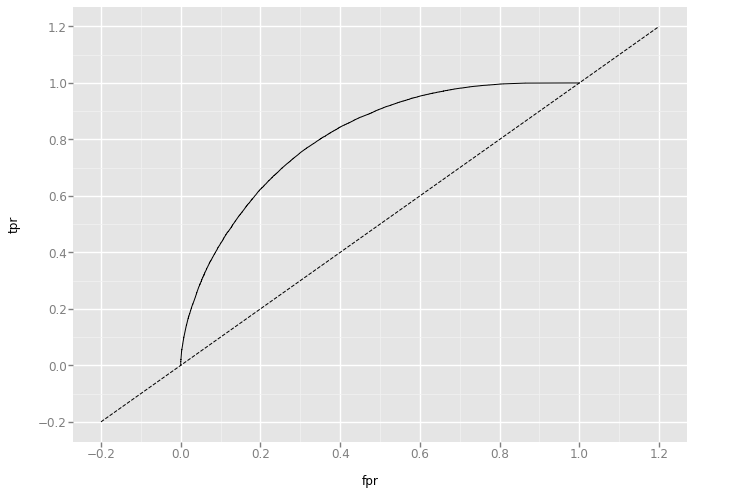

<ggplot: (8772627775217)>

In [50]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

In [52]:
auc = metrics.auc(fpr,tpr)

In [53]:
auc

0.80651961759961743

In [91]:
sum(target)

34561

In [92]:
len(target)

108129

In [94]:
34561.0/108129.0

0.3196274819891056